##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Retraining an Image Classifier


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction

Image classification models have millions of parameters. Training them from
scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

This Colab demonstrates how to build a Keras model for classifying five species of flowers by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. Optionally, the feature extractor can be trained ("fine-tuned") alongside the newly added classifier.

### Looking for a tool instead?

This is a TensorFlow coding tutorial. If you want a tool that just builds the TensorFlow or TF Lite model for, take a look at the [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) command-line tool that gets [installed](https://www.tensorflow.org/hub/installation) by the PIP package `tensorflow-hub[make_image_classifier]`, or at [this](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb) TF Lite colab.


## Setup

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.2.0
Hub version: 0.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available


## Select the TF2 SavedModel module to use

For starters, use https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4. The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that `hub.Modules` for TF 1.x won't work here.)

In [3]:
module_selection = ("mobilenet_v2_100_224", 224) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

     8192/228813984 [..............................] - ETA: 5s

  8396800/228813984 [>.............................] - ETA: 24s

 21921792/228813984 [=>............................] - ETA: 9s 

 36200448/228813984 [===>..........................] - ETA: 5s

 41951232/228813984 [====>.........................] - ETA: 4s

 50339840/228813984 [=====>........................] - ETA: 4s

 63946752/228813984 [=======>......................] - ETA: 3s

 67117056/228813984 [=======>......................] - ETA: 4s

 80732160/228813984 [=========>....................] - ETA: 3s

 92012544/228813984 [===========>..................] - ETA: 2s

100671488/228813984 [============>.................] - ETA: 4s

112279552/228813984 [=============>................] - ETA: 3s

125263872/228813984 [===============>..............] - ETA: 2s

134225920/228813984 [================>.............] - ETA: 2s

147185664/228813984 [==================>...........] - ETA: 2s

160358400/228813984 [====================>.........] - ETA: 1s

173391872/228813984 [=====================>........] - ETA: 1s

176168960/228813984 [======================>.......] - ETA: 1s

189513728/228813984 [=======================>......] - ETA: 1s

202809344/228813984 [=========================>....] - ETA: 0s

216137728/228813984 [===========================>..] - ETA: 0s

228818944/228813984 [==============================] - 5s 0us/step


In [5]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [6]:
do_fine_tuning = False #@param {type:"boolean"}

In [7]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Training the model

In [8]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [9]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5


 1/91 [..............................] - ETA: 0s - loss: 2.0540 - accuracy: 0.1562

 3/91 [..............................] - ETA: 5s - loss: 1.9046 - accuracy: 0.2292

 4/91 [>.............................] - ETA: 6s - loss: 1.8119 - accuracy: 0.2578

 5/91 [>.............................] - ETA: 7s - loss: 1.7319 - accuracy: 0.3000

 6/91 [>.............................] - ETA: 8s - loss: 1.6894 - accuracy: 0.3177

 7/91 [=>............................] - ETA: 8s - loss: 1.6574 - accuracy: 0.3393

 8/91 [=>............................] - ETA: 8s - loss: 1.6212 - accuracy: 0.3711

 9/91 [=>............................] - ETA: 9s - loss: 1.6102 - accuracy: 0.3715

10/91 [==>...........................] - ETA: 9s - loss: 1.5807 - accuracy: 0.3906

11/91 [==>...........................] - ETA: 9s - loss: 1.5598 - accuracy: 0.4091

12/91 [==>...........................] - ETA: 9s - loss: 1.5107 - accuracy: 0.4323

13/91 [===>..........................] - ETA: 9s - loss: 1.4851 - accuracy: 0.4399

14/91 [===>..........................] - ETA: 9s - loss: 1.4393 - accuracy: 0.4643

15/91 [===>..........................] - ETA: 9s - loss: 1.4048 - accuracy: 0.4771

16/91 [====>.........................] - ETA: 9s - loss: 1.3858 - accuracy: 0.4883

17/91 [====>.........................] - ETA: 9s - loss: 1.3778 - accuracy: 0.4963

18/91 [====>.........................] - ETA: 9s - loss: 1.3571 - accuracy: 0.5122

19/91 [=====>........................] - ETA: 8s - loss: 1.3312 - accuracy: 0.5280

20/91 [=====>........................] - ETA: 8s - loss: 1.3095 - accuracy: 0.5422

21/91 [=====>........................] - ETA: 8s - loss: 1.2938 - accuracy: 0.5506

22/91 [======>.......................] - ETA: 8s - loss: 1.2678 - accuracy: 0.5653

23/91 [======>.......................] - ETA: 8s - loss: 1.2603 - accuracy: 0.5707

24/91 [======>.......................] - ETA: 8s - loss: 1.2511 - accuracy: 0.5742

25/91 [=======>......................] - ETA: 8s - loss: 1.2383 - accuracy: 0.5825

26/91 [=======>......................] - ETA: 8s - loss: 1.2197 - accuracy: 0.5938

27/91 [=======>......................] - ETA: 8s - loss: 1.2077 - accuracy: 0.6019

28/91 [========>.....................] - ETA: 8s - loss: 1.1929 - accuracy: 0.6094

29/91 [========>.....................] - ETA: 7s - loss: 1.1807 - accuracy: 0.6142

30/91 [========>.....................] - ETA: 7s - loss: 1.1745 - accuracy: 0.6187

31/91 [=========>....................] - ETA: 7s - loss: 1.1561 - accuracy: 0.6300

32/91 [=========>....................] - ETA: 7s - loss: 1.1455 - accuracy: 0.6348

33/91 [=========>....................] - ETA: 7s - loss: 1.1365 - accuracy: 0.6383

34/91 [==========>...................] - ETA: 7s - loss: 1.1277 - accuracy: 0.6434

35/91 [==========>...................] - ETA: 7s - loss: 1.1153 - accuracy: 0.6500

36/91 [==========>...................] - ETA: 7s - loss: 1.1090 - accuracy: 0.6545

37/91 [===========>..................] - ETA: 6s - loss: 1.0981 - accuracy: 0.6605

38/91 [===========>..................] - ETA: 6s - loss: 1.0972 - accuracy: 0.6612

39/91 [===========>..................] - ETA: 6s - loss: 1.0877 - accuracy: 0.6643

40/91 [============>.................] - ETA: 6s - loss: 1.0787 - accuracy: 0.6687

41/91 [============>.................] - ETA: 6s - loss: 1.0738 - accuracy: 0.6723

42/91 [============>.................] - ETA: 6s - loss: 1.0687 - accuracy: 0.6756

43/91 [=============>................] - ETA: 6s - loss: 1.0612 - accuracy: 0.6802

44/91 [=============>................] - ETA: 6s - loss: 1.0582 - accuracy: 0.6832

45/91 [=============>................] - ETA: 5s - loss: 1.0526 - accuracy: 0.6861

46/91 [==============>...............] - ETA: 5s - loss: 1.0469 - accuracy: 0.6889

47/91 [==============>...............] - ETA: 5s - loss: 1.0438 - accuracy: 0.6908

48/91 [==============>...............] - ETA: 5s - loss: 1.0390 - accuracy: 0.6908

49/91 [===============>..............] - ETA: 5s - loss: 1.0349 - accuracy: 0.6926

50/91 [===============>..............] - ETA: 5s - loss: 1.0362 - accuracy: 0.6919

51/91 [===============>..............] - ETA: 5s - loss: 1.0306 - accuracy: 0.6955

52/91 [================>.............] - ETA: 5s - loss: 1.0250 - accuracy: 0.6983

53/91 [================>.............] - ETA: 4s - loss: 1.0191 - accuracy: 0.7011

54/91 [================>.............] - ETA: 4s - loss: 1.0172 - accuracy: 0.7037

55/91 [=================>............] - ETA: 4s - loss: 1.0131 - accuracy: 0.7068

56/91 [=================>............] - ETA: 4s - loss: 1.0097 - accuracy: 0.7098

57/91 [=================>............] - ETA: 4s - loss: 1.0093 - accuracy: 0.7111

58/91 [==================>...........] - ETA: 4s - loss: 1.0033 - accuracy: 0.7144

59/91 [==================>...........] - ETA: 4s - loss: 1.0008 - accuracy: 0.7153

61/91 [===================>..........] - ETA: 3s - loss: 0.9997 - accuracy: 0.7185

62/91 [===================>..........] - ETA: 3s - loss: 0.9968 - accuracy: 0.7211

63/91 [===================>..........] - ETA: 3s - loss: 0.9944 - accuracy: 0.7215

64/91 [====================>.........] - ETA: 3s - loss: 0.9905 - accuracy: 0.7225

65/91 [====================>.........] - ETA: 3s - loss: 0.9854 - accuracy: 0.7253

66/91 [====================>.........] - ETA: 3s - loss: 0.9801 - accuracy: 0.7285

67/91 [=====================>........] - ETA: 3s - loss: 0.9771 - accuracy: 0.7293

68/91 [=====================>........] - ETA: 2s - loss: 0.9739 - accuracy: 0.7315

69/91 [=====================>........] - ETA: 2s - loss: 0.9690 - accuracy: 0.7335

70/91 [======================>.......] - ETA: 2s - loss: 0.9686 - accuracy: 0.7329

71/91 [======================>.......] - ETA: 2s - loss: 0.9670 - accuracy: 0.7331

72/91 [======================>.......] - ETA: 2s - loss: 0.9654 - accuracy: 0.7334

73/91 [=======================>......] - ETA: 2s - loss: 0.9626 - accuracy: 0.7349

74/91 [=======================>......] - ETA: 2s - loss: 0.9628 - accuracy: 0.7359

75/91 [=======================>......] - ETA: 2s - loss: 0.9605 - accuracy: 0.7370

76/91 [========================>.....] - ETA: 1s - loss: 0.9568 - accuracy: 0.7388

77/91 [========================>.....] - ETA: 1s - loss: 0.9540 - accuracy: 0.7393

78/91 [========================>.....] - ETA: 1s - loss: 0.9502 - accuracy: 0.7415

79/91 [=========================>....] - ETA: 1s - loss: 0.9489 - accuracy: 0.7424

80/91 [=========================>....] - ETA: 1s - loss: 0.9475 - accuracy: 0.7432

81/91 [=========================>....] - ETA: 1s - loss: 0.9445 - accuracy: 0.7453

82/91 [==========================>...] - ETA: 1s - loss: 0.9420 - accuracy: 0.7457

83/91 [==========================>...] - ETA: 1s - loss: 0.9407 - accuracy: 0.7465

84/91 [==========================>...] - ETA: 0s - loss: 0.9384 - accuracy: 0.7484

85/91 [===========================>..] - ETA: 0s - loss: 0.9359 - accuracy: 0.7495

86/91 [===========================>..] - ETA: 0s - loss: 0.9368 - accuracy: 0.7492

87/91 [===========================>..] - ETA: 0s - loss: 0.9342 - accuracy: 0.7506

88/91 [============================>.] - ETA: 0s - loss: 0.9325 - accuracy: 0.7520

89/91 [============================>.] - ETA: 0s - loss: 0.9294 - accuracy: 0.7538

90/91 [============================>.] - ETA: 0s - loss: 0.9283 - accuracy: 0.7544

91/91 [==============================] - ETA: 0s - loss: 0.9266 - accuracy: 0.7558

91/91 [==============================] - 16s 174ms/step - loss: 0.9266 - accuracy: 0.7558 - val_loss: 0.7538 - val_accuracy: 0.8338


Epoch 2/5
 1/91 [..............................] - ETA: 0s - loss: 0.7280 - accuracy: 0.8750

 2/91 [..............................] - ETA: 6s - loss: 0.6891 - accuracy: 0.8750

 3/91 [..............................] - ETA: 8s - loss: 0.6841 - accuracy: 0.8750

 4/91 [>.............................] - ETA: 8s - loss: 0.6745 - accuracy: 0.8828

 5/91 [>.............................] - ETA: 8s - loss: 0.6638 - accuracy: 0.8839

 6/91 [>.............................] - ETA: 9s - loss: 0.6859 - accuracy: 0.8717

 7/91 [=>............................] - ETA: 9s - loss: 0.6857 - accuracy: 0.8676

 8/91 [=>............................] - ETA: 9s - loss: 0.6732 - accuracy: 0.8765

 9/91 [=>............................] - ETA: 9s - loss: 0.6877 - accuracy: 0.8728

10/91 [==>...........................] - ETA: 9s - loss: 0.6855 - accuracy: 0.8794

11/91 [==>...........................] - ETA: 9s - loss: 0.6846 - accuracy: 0.8818

12/91 [==>...........................] - ETA: 9s - loss: 0.6819 - accuracy: 0.8813

13/91 [===>..........................] - ETA: 9s - loss: 0.6748 - accuracy: 0.8832

14/91 [===>..........................] - ETA: 9s - loss: 0.6717 - accuracy: 0.8826

15/91 [===>..........................] - ETA: 9s - loss: 0.6767 - accuracy: 0.8779

16/91 [====>.........................] - ETA: 9s - loss: 0.6781 - accuracy: 0.8757

17/91 [====>.........................] - ETA: 9s - loss: 0.6754 - accuracy: 0.8776

18/91 [====>.........................] - ETA: 8s - loss: 0.6682 - accuracy: 0.8844

19/91 [=====>........................] - ETA: 8s - loss: 0.6729 - accuracy: 0.8839

20/91 [=====>........................] - ETA: 8s - loss: 0.6739 - accuracy: 0.8866

21/91 [=====>........................] - ETA: 8s - loss: 0.6772 - accuracy: 0.8831

22/91 [======>.......................] - ETA: 8s - loss: 0.6815 - accuracy: 0.8827

23/91 [======>.......................] - ETA: 8s - loss: 0.6837 - accuracy: 0.8810

24/91 [======>.......................] - ETA: 8s - loss: 0.6844 - accuracy: 0.8807

25/91 [=======>......................] - ETA: 8s - loss: 0.6929 - accuracy: 0.8767

26/91 [=======>......................] - ETA: 8s - loss: 0.6907 - accuracy: 0.8767

27/91 [=======>......................] - ETA: 8s - loss: 0.6965 - accuracy: 0.8743

28/91 [========>.....................] - ETA: 8s - loss: 0.6976 - accuracy: 0.8732

29/91 [========>.....................] - ETA: 7s - loss: 0.6966 - accuracy: 0.8722

30/91 [========>.....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.8712

31/91 [=========>....................] - ETA: 7s - loss: 0.6935 - accuracy: 0.8734

32/91 [=========>....................] - ETA: 7s - loss: 0.6962 - accuracy: 0.8714

33/91 [=========>....................] - ETA: 7s - loss: 0.6956 - accuracy: 0.8716

34/91 [==========>...................] - ETA: 7s - loss: 0.6971 - accuracy: 0.8698

35/91 [==========>...................] - ETA: 7s - loss: 0.6987 - accuracy: 0.8691

36/91 [==========>...................] - ETA: 7s - loss: 0.6967 - accuracy: 0.8710

37/91 [===========>..................] - ETA: 6s - loss: 0.6965 - accuracy: 0.8711

38/91 [===========>..................] - ETA: 6s - loss: 0.6933 - accuracy: 0.8728

39/91 [===========>..................] - ETA: 6s - loss: 0.6924 - accuracy: 0.8737

40/91 [============>.................] - ETA: 6s - loss: 0.6886 - accuracy: 0.8769

41/91 [============>.................] - ETA: 6s - loss: 0.6867 - accuracy: 0.8791

42/91 [============>.................] - ETA: 6s - loss: 0.6878 - accuracy: 0.8790

43/91 [=============>................] - ETA: 6s - loss: 0.6846 - accuracy: 0.8811

44/91 [=============>................] - ETA: 6s - loss: 0.6861 - accuracy: 0.8795

45/91 [=============>................] - ETA: 5s - loss: 0.6891 - accuracy: 0.8774

46/91 [==============>...............] - ETA: 5s - loss: 0.6899 - accuracy: 0.8759

47/91 [==============>...............] - ETA: 5s - loss: 0.6923 - accuracy: 0.8746

48/91 [==============>...............] - ETA: 5s - loss: 0.6940 - accuracy: 0.8746

49/91 [===============>..............] - ETA: 5s - loss: 0.6958 - accuracy: 0.8740

50/91 [===============>..............] - ETA: 5s - loss: 0.6951 - accuracy: 0.8746

51/91 [===============>..............] - ETA: 5s - loss: 0.6966 - accuracy: 0.8740

52/91 [================>.............] - ETA: 5s - loss: 0.6972 - accuracy: 0.8734

53/91 [================>.............] - ETA: 4s - loss: 0.6993 - accuracy: 0.8723

54/91 [================>.............] - ETA: 4s - loss: 0.7007 - accuracy: 0.8706

55/91 [=================>............] - ETA: 4s - loss: 0.7018 - accuracy: 0.8684

56/91 [=================>............] - ETA: 4s - loss: 0.7027 - accuracy: 0.8679

57/91 [=================>............] - ETA: 4s - loss: 0.7023 - accuracy: 0.8675

58/91 [==================>...........] - ETA: 4s - loss: 0.7038 - accuracy: 0.8660

59/91 [==================>...........] - ETA: 4s - loss: 0.7027 - accuracy: 0.8662

60/91 [==================>...........] - ETA: 4s - loss: 0.7035 - accuracy: 0.8668

61/91 [===================>..........] - ETA: 3s - loss: 0.7015 - accuracy: 0.8680

62/91 [===================>..........] - ETA: 3s - loss: 0.7041 - accuracy: 0.8666

63/91 [===================>..........] - ETA: 3s - loss: 0.7031 - accuracy: 0.8662

64/91 [====================>.........] - ETA: 3s - loss: 0.7033 - accuracy: 0.8664

65/91 [====================>.........] - ETA: 3s - loss: 0.7023 - accuracy: 0.8675

66/91 [====================>.........] - ETA: 3s - loss: 0.7027 - accuracy: 0.8666

67/91 [=====================>........] - ETA: 3s - loss: 0.7032 - accuracy: 0.8649

68/91 [=====================>........] - ETA: 2s - loss: 0.7035 - accuracy: 0.8646

69/91 [=====================>........] - ETA: 2s - loss: 0.7032 - accuracy: 0.8638

70/91 [======================>.......] - ETA: 2s - loss: 0.7026 - accuracy: 0.8640

71/91 [======================>.......] - ETA: 2s - loss: 0.7014 - accuracy: 0.8646

72/91 [======================>.......] - ETA: 2s - loss: 0.6996 - accuracy: 0.8660

73/91 [=======================>......] - ETA: 2s - loss: 0.6973 - accuracy: 0.8674

74/91 [=======================>......] - ETA: 2s - loss: 0.6981 - accuracy: 0.8667

75/91 [=======================>......] - ETA: 2s - loss: 0.6991 - accuracy: 0.8668

76/91 [========================>.....] - ETA: 1s - loss: 0.6983 - accuracy: 0.8673

77/91 [========================>.....] - ETA: 1s - loss: 0.6986 - accuracy: 0.8674

78/91 [========================>.....] - ETA: 1s - loss: 0.6976 - accuracy: 0.8683

79/91 [=========================>....] - ETA: 1s - loss: 0.6964 - accuracy: 0.8688

80/91 [=========================>....] - ETA: 1s - loss: 0.6945 - accuracy: 0.8697

81/91 [=========================>....] - ETA: 1s - loss: 0.6927 - accuracy: 0.8709

82/91 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.8706

83/91 [==========================>...] - ETA: 1s - loss: 0.6949 - accuracy: 0.8706

84/91 [==========================>...] - ETA: 0s - loss: 0.6950 - accuracy: 0.8707

85/91 [===========================>..] - ETA: 0s - loss: 0.6940 - accuracy: 0.8715

86/91 [===========================>..] - ETA: 0s - loss: 0.6948 - accuracy: 0.8715

87/91 [===========================>..] - ETA: 0s - loss: 0.6941 - accuracy: 0.8723

88/91 [============================>.] - ETA: 0s - loss: 0.6954 - accuracy: 0.8716

89/91 [============================>.] - ETA: 0s - loss: 0.6953 - accuracy: 0.8723

90/91 [============================>.] - ETA: 0s - loss: 0.6957 - accuracy: 0.8723

91/91 [==============================] - ETA: 0s - loss: 0.6976 - accuracy: 0.8710

91/91 [==============================] - 15s 165ms/step - loss: 0.6976 - accuracy: 0.8710 - val_loss: 0.7071 - val_accuracy: 0.8665


Epoch 3/5
 1/91 [..............................] - ETA: 0s - loss: 0.7101 - accuracy: 0.8750

 2/91 [..............................] - ETA: 5s - loss: 0.7018 - accuracy: 0.8594

 3/91 [..............................] - ETA: 7s - loss: 0.7049 - accuracy: 0.8646

 4/91 [>.............................] - ETA: 8s - loss: 0.6627 - accuracy: 0.8906

 5/91 [>.............................] - ETA: 8s - loss: 0.6376 - accuracy: 0.9062

 6/91 [>.............................] - ETA: 9s - loss: 0.6288 - accuracy: 0.9115

 7/91 [=>............................] - ETA: 9s - loss: 0.6291 - accuracy: 0.9107

 8/91 [=>............................] - ETA: 9s - loss: 0.6351 - accuracy: 0.9102

 9/91 [=>............................] - ETA: 9s - loss: 0.6312 - accuracy: 0.9097

10/91 [==>...........................] - ETA: 9s - loss: 0.6281 - accuracy: 0.9125

11/91 [==>...........................] - ETA: 9s - loss: 0.6266 - accuracy: 0.9119

12/91 [==>...........................] - ETA: 9s - loss: 0.6291 - accuracy: 0.9141

13/91 [===>..........................] - ETA: 9s - loss: 0.6269 - accuracy: 0.9135

14/91 [===>..........................] - ETA: 9s - loss: 0.6196 - accuracy: 0.9152

15/91 [===>..........................] - ETA: 9s - loss: 0.6216 - accuracy: 0.9104

16/91 [====>.........................] - ETA: 8s - loss: 0.6259 - accuracy: 0.9062

17/91 [====>.........................] - ETA: 8s - loss: 0.6236 - accuracy: 0.9118

18/91 [====>.........................] - ETA: 8s - loss: 0.6199 - accuracy: 0.9132

19/91 [=====>........................] - ETA: 8s - loss: 0.6217 - accuracy: 0.9128

20/91 [=====>........................] - ETA: 8s - loss: 0.6222 - accuracy: 0.9109

21/91 [=====>........................] - ETA: 8s - loss: 0.6201 - accuracy: 0.9137

22/91 [======>.......................] - ETA: 8s - loss: 0.6207 - accuracy: 0.9119

23/91 [======>.......................] - ETA: 8s - loss: 0.6202 - accuracy: 0.9130

24/91 [======>.......................] - ETA: 8s - loss: 0.6161 - accuracy: 0.9167

25/91 [=======>......................] - ETA: 8s - loss: 0.6135 - accuracy: 0.9200

26/91 [=======>......................] - ETA: 7s - loss: 0.6195 - accuracy: 0.9195

27/91 [=======>......................] - ETA: 7s - loss: 0.6182 - accuracy: 0.9213

28/91 [========>.....................] - ETA: 7s - loss: 0.6219 - accuracy: 0.9208

29/91 [========>.....................] - ETA: 7s - loss: 0.6211 - accuracy: 0.9213

30/91 [========>.....................] - ETA: 7s - loss: 0.6228 - accuracy: 0.9208

31/91 [=========>....................] - ETA: 7s - loss: 0.6233 - accuracy: 0.9224

32/91 [=========>....................] - ETA: 7s - loss: 0.6222 - accuracy: 0.9209

33/91 [=========>....................] - ETA: 7s - loss: 0.6198 - accuracy: 0.9223

34/91 [==========>...................] - ETA: 7s - loss: 0.6196 - accuracy: 0.9228

35/91 [==========>...................] - ETA: 7s - loss: 0.6180 - accuracy: 0.9223

36/91 [==========>...................] - ETA: 6s - loss: 0.6195 - accuracy: 0.9219

37/91 [===========>..................] - ETA: 6s - loss: 0.6172 - accuracy: 0.9240

38/91 [===========>..................] - ETA: 6s - loss: 0.6183 - accuracy: 0.9235

39/91 [===========>..................] - ETA: 6s - loss: 0.6183 - accuracy: 0.9223

40/91 [============>.................] - ETA: 6s - loss: 0.6160 - accuracy: 0.9239

41/91 [============>.................] - ETA: 6s - loss: 0.6231 - accuracy: 0.9204

42/91 [============>.................] - ETA: 6s - loss: 0.6222 - accuracy: 0.9208

43/91 [=============>................] - ETA: 6s - loss: 0.6234 - accuracy: 0.9198

44/91 [=============>................] - ETA: 5s - loss: 0.6239 - accuracy: 0.9195

45/91 [=============>................] - ETA: 5s - loss: 0.6279 - accuracy: 0.9178

46/91 [==============>...............] - ETA: 5s - loss: 0.6273 - accuracy: 0.9182

47/91 [==============>...............] - ETA: 5s - loss: 0.6272 - accuracy: 0.9193

48/91 [==============>...............] - ETA: 5s - loss: 0.6296 - accuracy: 0.9177

49/91 [===============>..............] - ETA: 5s - loss: 0.6288 - accuracy: 0.9181

50/91 [===============>..............] - ETA: 5s - loss: 0.6278 - accuracy: 0.9191

51/91 [===============>..............] - ETA: 5s - loss: 0.6272 - accuracy: 0.9176

52/91 [================>.............] - ETA: 5s - loss: 0.6272 - accuracy: 0.9174

53/91 [================>.............] - ETA: 4s - loss: 0.6274 - accuracy: 0.9172

54/91 [================>.............] - ETA: 4s - loss: 0.6281 - accuracy: 0.9176

55/91 [=================>............] - ETA: 4s - loss: 0.6294 - accuracy: 0.9174

56/91 [=================>............] - ETA: 4s - loss: 0.6303 - accuracy: 0.9172

57/91 [=================>............] - ETA: 4s - loss: 0.6326 - accuracy: 0.9164

58/91 [==================>...........] - ETA: 4s - loss: 0.6324 - accuracy: 0.9157

59/91 [==================>...........] - ETA: 4s - loss: 0.6314 - accuracy: 0.9161

60/91 [==================>...........] - ETA: 3s - loss: 0.6329 - accuracy: 0.9138

61/91 [===================>..........] - ETA: 3s - loss: 0.6344 - accuracy: 0.9122

62/91 [===================>..........] - ETA: 3s - loss: 0.6348 - accuracy: 0.9116

63/91 [===================>..........] - ETA: 3s - loss: 0.6349 - accuracy: 0.9115

64/91 [====================>.........] - ETA: 3s - loss: 0.6378 - accuracy: 0.9099

65/91 [====================>.........] - ETA: 3s - loss: 0.6387 - accuracy: 0.9089

66/91 [====================>.........] - ETA: 3s - loss: 0.6388 - accuracy: 0.9098

67/91 [=====================>........] - ETA: 3s - loss: 0.6405 - accuracy: 0.9088

68/91 [=====================>........] - ETA: 2s - loss: 0.6389 - accuracy: 0.9102

69/91 [=====================>........] - ETA: 2s - loss: 0.6391 - accuracy: 0.9092

70/91 [======================>.......] - ETA: 2s - loss: 0.6397 - accuracy: 0.9087

71/91 [======================>.......] - ETA: 2s - loss: 0.6398 - accuracy: 0.9082

72/91 [======================>.......] - ETA: 2s - loss: 0.6392 - accuracy: 0.9078

73/91 [=======================>......] - ETA: 2s - loss: 0.6390 - accuracy: 0.9073

74/91 [=======================>......] - ETA: 2s - loss: 0.6387 - accuracy: 0.9077

75/91 [=======================>......] - ETA: 2s - loss: 0.6402 - accuracy: 0.9069

76/91 [========================>.....] - ETA: 1s - loss: 0.6421 - accuracy: 0.9061

77/91 [========================>.....] - ETA: 1s - loss: 0.6435 - accuracy: 0.9061

78/91 [========================>.....] - ETA: 1s - loss: 0.6433 - accuracy: 0.9065

79/91 [=========================>....] - ETA: 1s - loss: 0.6439 - accuracy: 0.9061

80/91 [=========================>....] - ETA: 1s - loss: 0.6435 - accuracy: 0.9065

81/91 [=========================>....] - ETA: 1s - loss: 0.6430 - accuracy: 0.9076

82/91 [==========================>...] - ETA: 1s - loss: 0.6438 - accuracy: 0.9068

83/91 [==========================>...] - ETA: 1s - loss: 0.6442 - accuracy: 0.9072

84/91 [==========================>...] - ETA: 0s - loss: 0.6436 - accuracy: 0.9076

85/91 [===========================>..] - ETA: 0s - loss: 0.6427 - accuracy: 0.9079

86/91 [===========================>..] - ETA: 0s - loss: 0.6437 - accuracy: 0.9068

87/91 [===========================>..] - ETA: 0s - loss: 0.6437 - accuracy: 0.9064

88/91 [============================>.] - ETA: 0s - loss: 0.6449 - accuracy: 0.9057

89/91 [============================>.] - ETA: 0s - loss: 0.6442 - accuracy: 0.9064

90/91 [============================>.] - ETA: 0s - loss: 0.6451 - accuracy: 0.9057

91/91 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.9061

91/91 [==============================] - 15s 164ms/step - loss: 0.6442 - accuracy: 0.9061 - val_loss: 0.6944 - val_accuracy: 0.8636


Epoch 4/5
 1/91 [..............................] - ETA: 0s - loss: 0.6609 - accuracy: 0.8750

 2/91 [..............................] - ETA: 6s - loss: 0.6694 - accuracy: 0.8750

 3/91 [..............................] - ETA: 7s - loss: 0.6452 - accuracy: 0.8958

 4/91 [>.............................] - ETA: 8s - loss: 0.6212 - accuracy: 0.9219

 5/91 [>.............................] - ETA: 9s - loss: 0.6128 - accuracy: 0.9250

 6/91 [>.............................] - ETA: 9s - loss: 0.6549 - accuracy: 0.9062

 7/91 [=>............................] - ETA: 9s - loss: 0.6374 - accuracy: 0.9152

 8/91 [=>............................] - ETA: 9s - loss: 0.6372 - accuracy: 0.9141

 9/91 [=>............................] - ETA: 9s - loss: 0.6503 - accuracy: 0.9062

10/91 [==>...........................] - ETA: 9s - loss: 0.6546 - accuracy: 0.9000

11/91 [==>...........................] - ETA: 9s - loss: 0.6470 - accuracy: 0.9034

12/91 [==>...........................] - ETA: 9s - loss: 0.6421 - accuracy: 0.9036

13/91 [===>..........................] - ETA: 9s - loss: 0.6387 - accuracy: 0.9038

14/91 [===>..........................] - ETA: 9s - loss: 0.6345 - accuracy: 0.9085

15/91 [===>..........................] - ETA: 9s - loss: 0.6284 - accuracy: 0.9146

16/91 [====>.........................] - ETA: 9s - loss: 0.6289 - accuracy: 0.9141

17/91 [====>.........................] - ETA: 9s - loss: 0.6305 - accuracy: 0.9099

18/91 [====>.........................] - ETA: 8s - loss: 0.6311 - accuracy: 0.9080

19/91 [=====>........................] - ETA: 8s - loss: 0.6317 - accuracy: 0.9112

20/91 [=====>........................] - ETA: 8s - loss: 0.6319 - accuracy: 0.9141

21/91 [=====>........................] - ETA: 8s - loss: 0.6311 - accuracy: 0.9152

22/91 [======>.......................] - ETA: 8s - loss: 0.6278 - accuracy: 0.9176

23/91 [======>.......................] - ETA: 8s - loss: 0.6280 - accuracy: 0.9158

24/91 [======>.......................] - ETA: 8s - loss: 0.6343 - accuracy: 0.9167

25/91 [=======>......................] - ETA: 8s - loss: 0.6323 - accuracy: 0.9162

26/91 [=======>......................] - ETA: 8s - loss: 0.6319 - accuracy: 0.9147

27/91 [=======>......................] - ETA: 7s - loss: 0.6330 - accuracy: 0.9132

28/91 [========>.....................] - ETA: 7s - loss: 0.6306 - accuracy: 0.9141

29/91 [========>.....................] - ETA: 7s - loss: 0.6336 - accuracy: 0.9127

30/91 [========>.....................] - ETA: 7s - loss: 0.6323 - accuracy: 0.9125

31/91 [=========>....................] - ETA: 7s - loss: 0.6356 - accuracy: 0.9113

32/91 [=========>....................] - ETA: 7s - loss: 0.6341 - accuracy: 0.9121

33/91 [=========>....................] - ETA: 7s - loss: 0.6351 - accuracy: 0.9119

34/91 [==========>...................] - ETA: 7s - loss: 0.6369 - accuracy: 0.9099

35/91 [==========>...................] - ETA: 6s - loss: 0.6355 - accuracy: 0.9107

36/91 [==========>...................] - ETA: 6s - loss: 0.6337 - accuracy: 0.9123

37/91 [===========>..................] - ETA: 6s - loss: 0.6319 - accuracy: 0.9139

38/91 [===========>..................] - ETA: 6s - loss: 0.6314 - accuracy: 0.9145

39/91 [===========>..................] - ETA: 6s - loss: 0.6304 - accuracy: 0.9151

40/91 [============>.................] - ETA: 6s - loss: 0.6300 - accuracy: 0.9148

41/91 [============>.................] - ETA: 6s - loss: 0.6277 - accuracy: 0.9162

42/91 [============>.................] - ETA: 6s - loss: 0.6323 - accuracy: 0.9152

43/91 [=============>................] - ETA: 6s - loss: 0.6303 - accuracy: 0.9172

44/91 [=============>................] - ETA: 5s - loss: 0.6314 - accuracy: 0.9169

45/91 [=============>................] - ETA: 5s - loss: 0.6304 - accuracy: 0.9181

46/91 [==============>...............] - ETA: 5s - loss: 0.6283 - accuracy: 0.9192

47/91 [==============>...............] - ETA: 5s - loss: 0.6274 - accuracy: 0.9202

48/91 [==============>...............] - ETA: 5s - loss: 0.6270 - accuracy: 0.9199

49/91 [===============>..............] - ETA: 5s - loss: 0.6279 - accuracy: 0.9196

50/91 [===============>..............] - ETA: 5s - loss: 0.6281 - accuracy: 0.9194

51/91 [===============>..............] - ETA: 5s - loss: 0.6271 - accuracy: 0.9203

52/91 [================>.............] - ETA: 4s - loss: 0.6273 - accuracy: 0.9207

53/91 [================>.............] - ETA: 4s - loss: 0.6260 - accuracy: 0.9210

54/91 [================>.............] - ETA: 4s - loss: 0.6275 - accuracy: 0.9199

55/91 [=================>............] - ETA: 4s - loss: 0.6292 - accuracy: 0.9191

56/91 [=================>............] - ETA: 4s - loss: 0.6307 - accuracy: 0.9172

57/91 [=================>............] - ETA: 4s - loss: 0.6291 - accuracy: 0.9186

58/91 [==================>...........] - ETA: 4s - loss: 0.6289 - accuracy: 0.9190

59/91 [==================>...........] - ETA: 4s - loss: 0.6299 - accuracy: 0.9182

60/91 [==================>...........] - ETA: 3s - loss: 0.6302 - accuracy: 0.9180

61/91 [===================>..........] - ETA: 3s - loss: 0.6306 - accuracy: 0.9178

62/91 [===================>..........] - ETA: 3s - loss: 0.6327 - accuracy: 0.9161

63/91 [===================>..........] - ETA: 3s - loss: 0.6336 - accuracy: 0.9165

64/91 [====================>.........] - ETA: 3s - loss: 0.6354 - accuracy: 0.9153

65/91 [====================>.........] - ETA: 3s - loss: 0.6357 - accuracy: 0.9147

66/91 [====================>.........] - ETA: 3s - loss: 0.6356 - accuracy: 0.9146

67/91 [=====================>........] - ETA: 3s - loss: 0.6361 - accuracy: 0.9140

68/91 [=====================>........] - ETA: 2s - loss: 0.6360 - accuracy: 0.9143

69/91 [=====================>........] - ETA: 2s - loss: 0.6359 - accuracy: 0.9147

70/91 [======================>.......] - ETA: 2s - loss: 0.6341 - accuracy: 0.9154

71/91 [======================>.......] - ETA: 2s - loss: 0.6331 - accuracy: 0.9157

72/91 [======================>.......] - ETA: 2s - loss: 0.6333 - accuracy: 0.9147

73/91 [=======================>......] - ETA: 2s - loss: 0.6343 - accuracy: 0.9146

74/91 [=======================>......] - ETA: 2s - loss: 0.6339 - accuracy: 0.9149

75/91 [=======================>......] - ETA: 2s - loss: 0.6334 - accuracy: 0.9152

76/91 [========================>.....] - ETA: 1s - loss: 0.6324 - accuracy: 0.9155

77/91 [========================>.....] - ETA: 1s - loss: 0.6328 - accuracy: 0.9150

78/91 [========================>.....] - ETA: 1s - loss: 0.6325 - accuracy: 0.9149

79/91 [=========================>....] - ETA: 1s - loss: 0.6319 - accuracy: 0.9152

80/91 [=========================>....] - ETA: 1s - loss: 0.6317 - accuracy: 0.9147

81/91 [=========================>....] - ETA: 1s - loss: 0.6318 - accuracy: 0.9142

82/91 [==========================>...] - ETA: 1s - loss: 0.6316 - accuracy: 0.9145

83/91 [==========================>...] - ETA: 1s - loss: 0.6308 - accuracy: 0.9147

84/91 [==========================>...] - ETA: 0s - loss: 0.6310 - accuracy: 0.9146

85/91 [===========================>..] - ETA: 0s - loss: 0.6305 - accuracy: 0.9145

86/91 [===========================>..] - ETA: 0s - loss: 0.6297 - accuracy: 0.9152

87/91 [===========================>..] - ETA: 0s - loss: 0.6302 - accuracy: 0.9151

88/91 [============================>.] - ETA: 0s - loss: 0.6312 - accuracy: 0.9146

89/91 [============================>.] - ETA: 0s - loss: 0.6312 - accuracy: 0.9149

90/91 [============================>.] - ETA: 0s - loss: 0.6315 - accuracy: 0.9148

91/91 [==============================] - ETA: 0s - loss: 0.6320 - accuracy: 0.9143

91/91 [==============================] - 15s 162ms/step - loss: 0.6320 - accuracy: 0.9143 - val_loss: 0.6916 - val_accuracy: 0.8636


Epoch 5/5
 1/91 [..............................] - ETA: 0s - loss: 0.5302 - accuracy: 1.0000

 2/91 [..............................] - ETA: 4s - loss: 0.5327 - accuracy: 0.9661

 3/91 [..............................] - ETA: 6s - loss: 0.5522 - accuracy: 0.9560

 4/91 [>.............................] - ETA: 7s - loss: 0.5794 - accuracy: 0.9350

 5/91 [>.............................] - ETA: 8s - loss: 0.5823 - accuracy: 0.9419

 6/91 [>.............................] - ETA: 8s - loss: 0.6196 - accuracy: 0.9198

 7/91 [=>............................] - ETA: 9s - loss: 0.6198 - accuracy: 0.9178

 8/91 [=>............................] - ETA: 9s - loss: 0.6206 - accuracy: 0.9203

 9/91 [=>............................] - ETA: 9s - loss: 0.6066 - accuracy: 0.9223

10/91 [==>...........................] - ETA: 9s - loss: 0.6041 - accuracy: 0.9270

11/91 [==>...........................] - ETA: 9s - loss: 0.6052 - accuracy: 0.9280

12/91 [==>...........................] - ETA: 9s - loss: 0.5950 - accuracy: 0.9340

13/91 [===>..........................] - ETA: 9s - loss: 0.5943 - accuracy: 0.9343

14/91 [===>..........................] - ETA: 9s - loss: 0.6012 - accuracy: 0.9278

15/91 [===>..........................] - ETA: 9s - loss: 0.6023 - accuracy: 0.9284

16/91 [====>.........................] - ETA: 8s - loss: 0.6037 - accuracy: 0.9250

17/91 [====>.........................] - ETA: 8s - loss: 0.6033 - accuracy: 0.9276

18/91 [====>.........................] - ETA: 8s - loss: 0.6054 - accuracy: 0.9264

19/91 [=====>........................] - ETA: 8s - loss: 0.6009 - accuracy: 0.9287

20/91 [=====>........................] - ETA: 8s - loss: 0.6038 - accuracy: 0.9260

21/91 [=====>........................] - ETA: 8s - loss: 0.6010 - accuracy: 0.9295

22/91 [======>.......................] - ETA: 8s - loss: 0.5972 - accuracy: 0.9313

23/91 [======>.......................] - ETA: 8s - loss: 0.6020 - accuracy: 0.9275

24/91 [======>.......................] - ETA: 8s - loss: 0.5998 - accuracy: 0.9279

25/91 [=======>......................] - ETA: 8s - loss: 0.5987 - accuracy: 0.9283

26/91 [=======>......................] - ETA: 8s - loss: 0.5970 - accuracy: 0.9299

27/91 [=======>......................] - ETA: 7s - loss: 0.5993 - accuracy: 0.9290

28/91 [========>.....................] - ETA: 7s - loss: 0.5964 - accuracy: 0.9304

29/91 [========>.....................] - ETA: 7s - loss: 0.5970 - accuracy: 0.9307

30/91 [========>.....................] - ETA: 7s - loss: 0.5976 - accuracy: 0.9319

31/91 [=========>....................] - ETA: 7s - loss: 0.5984 - accuracy: 0.9311

32/91 [=========>....................] - ETA: 7s - loss: 0.5992 - accuracy: 0.9293

33/91 [=========>....................] - ETA: 7s - loss: 0.5976 - accuracy: 0.9305

34/91 [==========>...................] - ETA: 7s - loss: 0.5964 - accuracy: 0.9317

35/91 [==========>...................] - ETA: 6s - loss: 0.5967 - accuracy: 0.9318

36/91 [==========>...................] - ETA: 6s - loss: 0.5973 - accuracy: 0.9320

37/91 [===========>..................] - ETA: 6s - loss: 0.5944 - accuracy: 0.9338

38/91 [===========>..................] - ETA: 6s - loss: 0.5944 - accuracy: 0.9331

39/91 [===========>..................] - ETA: 6s - loss: 0.5951 - accuracy: 0.9340

40/91 [============>.................] - ETA: 6s - loss: 0.5935 - accuracy: 0.9349

41/91 [============>.................] - ETA: 6s - loss: 0.5950 - accuracy: 0.9342

42/91 [============>.................] - ETA: 6s - loss: 0.5981 - accuracy: 0.9328

43/91 [=============>................] - ETA: 6s - loss: 0.5991 - accuracy: 0.9322

44/91 [=============>................] - ETA: 5s - loss: 0.6006 - accuracy: 0.9316

45/91 [=============>................] - ETA: 5s - loss: 0.6004 - accuracy: 0.9317

46/91 [==============>...............] - ETA: 5s - loss: 0.6002 - accuracy: 0.9318

47/91 [==============>...............] - ETA: 5s - loss: 0.5986 - accuracy: 0.9333

48/91 [==============>...............] - ETA: 5s - loss: 0.5964 - accuracy: 0.9347

49/91 [===============>..............] - ETA: 5s - loss: 0.5968 - accuracy: 0.9347

50/91 [===============>..............] - ETA: 5s - loss: 0.5963 - accuracy: 0.9342

51/91 [===============>..............] - ETA: 5s - loss: 0.5962 - accuracy: 0.9342

52/91 [================>.............] - ETA: 4s - loss: 0.5961 - accuracy: 0.9349

53/91 [================>.............] - ETA: 4s - loss: 0.5964 - accuracy: 0.9338

54/91 [================>.............] - ETA: 4s - loss: 0.5996 - accuracy: 0.9321

55/91 [=================>............] - ETA: 4s - loss: 0.5999 - accuracy: 0.9316

56/91 [=================>............] - ETA: 4s - loss: 0.6038 - accuracy: 0.9289

57/91 [=================>............] - ETA: 4s - loss: 0.6036 - accuracy: 0.9291

58/91 [==================>...........] - ETA: 4s - loss: 0.6043 - accuracy: 0.9287

59/91 [==================>...........] - ETA: 4s - loss: 0.6042 - accuracy: 0.9288

60/91 [==================>...........] - ETA: 3s - loss: 0.6039 - accuracy: 0.9295

61/91 [===================>..........] - ETA: 3s - loss: 0.6097 - accuracy: 0.9266

62/91 [===================>..........] - ETA: 3s - loss: 0.6087 - accuracy: 0.9272

63/91 [===================>..........] - ETA: 3s - loss: 0.6093 - accuracy: 0.9269

64/91 [====================>.........] - ETA: 3s - loss: 0.6092 - accuracy: 0.9266

65/91 [====================>.........] - ETA: 3s - loss: 0.6087 - accuracy: 0.9272

66/91 [====================>.........] - ETA: 3s - loss: 0.6083 - accuracy: 0.9279

67/91 [=====================>........] - ETA: 3s - loss: 0.6079 - accuracy: 0.9280

68/91 [=====================>........] - ETA: 2s - loss: 0.6111 - accuracy: 0.9258

69/91 [=====================>........] - ETA: 2s - loss: 0.6115 - accuracy: 0.9256

70/91 [======================>.......] - ETA: 2s - loss: 0.6111 - accuracy: 0.9257

71/91 [======================>.......] - ETA: 2s - loss: 0.6102 - accuracy: 0.9259

72/91 [======================>.......] - ETA: 2s - loss: 0.6101 - accuracy: 0.9261

73/91 [=======================>......] - ETA: 2s - loss: 0.6109 - accuracy: 0.9258

74/91 [=======================>......] - ETA: 2s - loss: 0.6111 - accuracy: 0.9259

75/91 [=======================>......] - ETA: 2s - loss: 0.6109 - accuracy: 0.9257

76/91 [========================>.....] - ETA: 1s - loss: 0.6104 - accuracy: 0.9262

77/91 [========================>.....] - ETA: 1s - loss: 0.6109 - accuracy: 0.9256

78/91 [========================>.....] - ETA: 1s - loss: 0.6105 - accuracy: 0.9261

79/91 [=========================>....] - ETA: 1s - loss: 0.6096 - accuracy: 0.9267

80/91 [=========================>....] - ETA: 1s - loss: 0.6092 - accuracy: 0.9264

81/91 [=========================>....] - ETA: 1s - loss: 0.6088 - accuracy: 0.9269

82/91 [==========================>...] - ETA: 1s - loss: 0.6078 - accuracy: 0.9275

83/91 [==========================>...] - ETA: 1s - loss: 0.6069 - accuracy: 0.9280

84/91 [==========================>...] - ETA: 0s - loss: 0.6068 - accuracy: 0.9284

85/91 [===========================>..] - ETA: 0s - loss: 0.6060 - accuracy: 0.9289

86/91 [===========================>..] - ETA: 0s - loss: 0.6075 - accuracy: 0.9279

87/91 [===========================>..] - ETA: 0s - loss: 0.6067 - accuracy: 0.9288

88/91 [============================>.] - ETA: 0s - loss: 0.6062 - accuracy: 0.9292

89/91 [============================>.] - ETA: 0s - loss: 0.6066 - accuracy: 0.9293

90/91 [============================>.] - ETA: 0s - loss: 0.6063 - accuracy: 0.9290

91/91 [==============================] - ETA: 0s - loss: 0.6055 - accuracy: 0.9295

91/91 [==============================] - 15s 162ms/step - loss: 0.6055 - accuracy: 0.9295 - val_loss: 0.6934 - val_accuracy: 0.8750


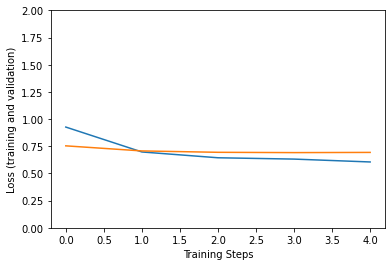

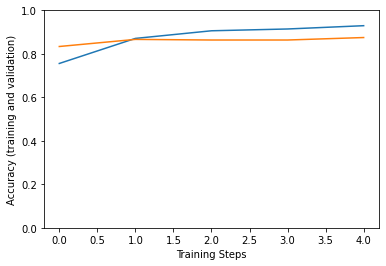

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Finally, the trained model can be saved for deployment to TF Serving or TF Lite (on mobile) as follows.

In [11]:
saved_model_path = "/tmp/saved_flowers_model"
tf.saved_model.save(model, saved_model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


## Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TF Lite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TF Lite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like EdgeTPU.

In [0]:
#@title Optimization settings
# docs_infra: no_execute
# TODO(b/156102192)
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open("/tmp/lite_flowers_model", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

In [0]:
# docs_infra: no_execute
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [0]:
#@markdown For rapid experimentation, start with a moderate number of examples.
# docs_infra: no_execute
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_generator
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))